In [3]:
!pip install xgboost
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV

In [122]:
# Read data
train = pd.read_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\train.csv')
test = pd.read_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [123]:
# Check for duplicates
idsUnique = len(set(train.User_ID))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 544177 duplicate IDs for 550068 total entries


Text(0.5, 1.0, 'Purchase amount Distribution')

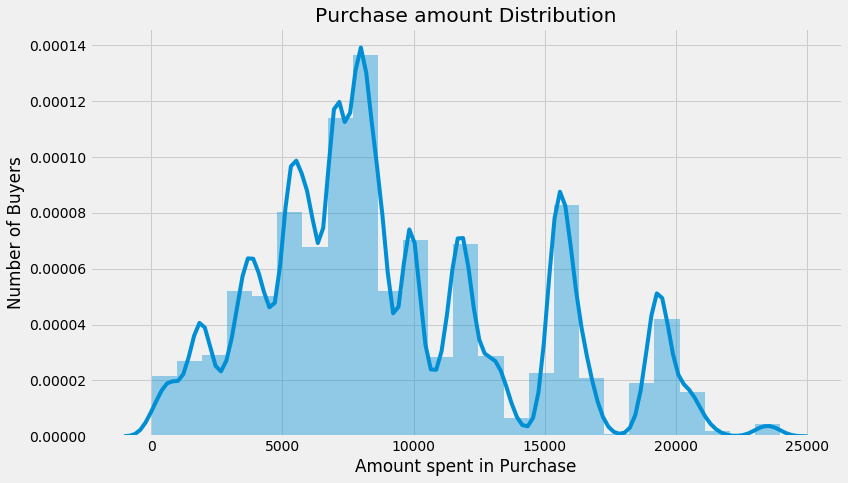

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.distplot(train.Purchase, bins = 25)
plt.xlabel("Amount spent in Purchase")
plt.ylabel("Number of Buyers")
plt.title("Purchase amount Distribution")

In [14]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [15]:
print ("Skew is:", train.Purchase.skew())
print("Kurtosis: %f" % train.Purchase.kurt())

Skew is: 0.6001400037087128
Kurtosis: -0.338378


In [16]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

User_ID                 int64
Occupation              int64
Marital_Status          int64
Product_Category_1      int64
Product_Category_2    float64
Product_Category_3    float64
Purchase                int64
dtype: object

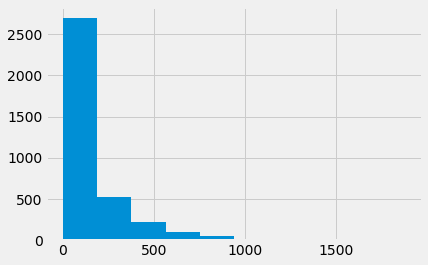

In [58]:
train.Product_ID.value_counts().hist()

In [17]:
train.Occupation.value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

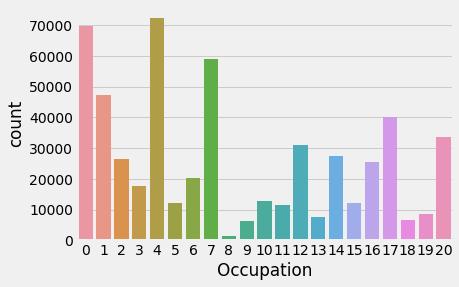

In [18]:
sns.countplot(train.Occupation)

In [19]:
train.Marital_Status.value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

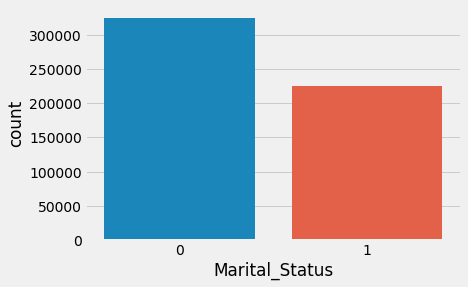

In [20]:
sns.countplot(train.Marital_Status)

In [21]:
# categorical columns that i chose
categorical_columns = ["Product_ID", "Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years",
                       "Marital_Status", "Product_Category_1", "Product_Category_2", "Product_Category_3"]

In [61]:
train.City_Category.value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [22]:
train.Product_Category_1.value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

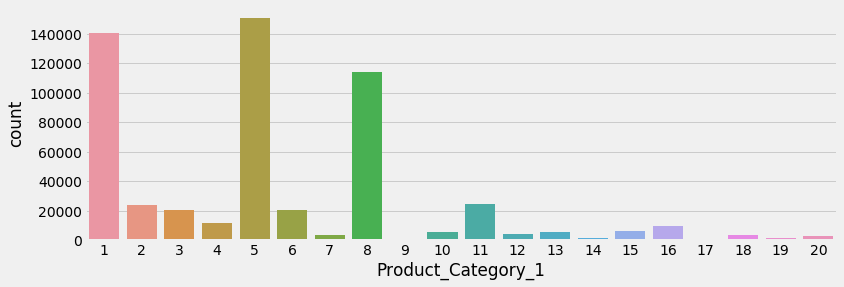

In [124]:
sns.countplot(train.Product_Category_1)

In [24]:
train.Product_Category_2.value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

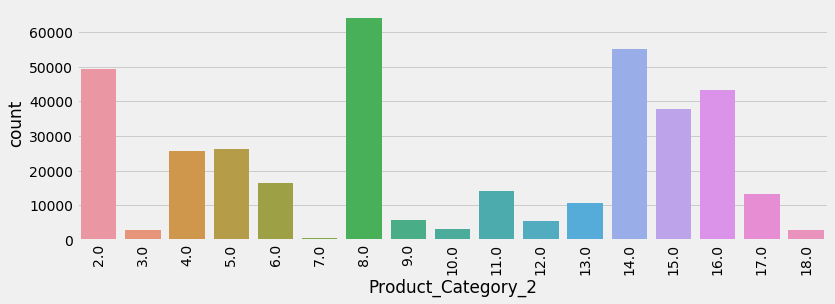

In [125]:
sns.countplot(train.Product_Category_2)
plt.xticks(rotation=90)

In [27]:
train.Product_Category_3.value_counts()

16.0    32636
15.0    28013
14.0    18428
17.0    16702
5.0     16658
8.0     12562
9.0     11579
12.0     9246
13.0     5459
6.0      4890
18.0     4629
4.0      1875
11.0     1805
10.0     1726
3.0       613
Name: Product_Category_3, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

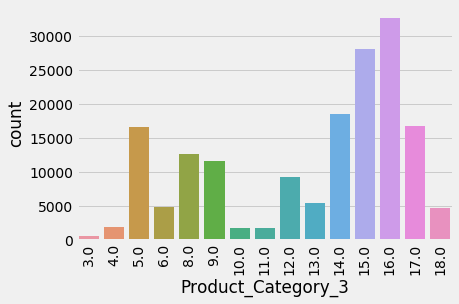

In [28]:
sns.countplot(train.Product_Category_3)
plt.xticks(rotation=90)

In [65]:
train.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023971,0.020443,0.003825,0.001529,0.003419,0.083918
Occupation,-0.023971,1.000000,0.024280,-0.007618,-0.000384,0.013263,-0.001673
Marital_Status,0.020443,0.024280,1.000000,0.019888,0.015138,0.019473,0.000884
Product_Category_1,0.003825,-0.007618,0.019888,1.000000,0.540583,0.229678,0.071965
Product_Category_2,0.001529,-0.000384,0.015138,0.540583,1.000000,0.543649,-0.000948
Product_Category_3,0.003419,0.013263,0.019473,0.229678,0.543649,1.000000,0.003510
Purchase,0.083918,-0.001673,0.000884,0.071965,-0.000948,0.003510,1.000000


In [30]:
corr = numeric_features.corr()

print(corr['Purchase'].sort_values(ascending=False)[:10], '\n')
print(corr['Purchase'].sort_values(ascending=False)[-10:])

Purchase              1.000000
Occupation            0.020833
User_ID               0.004716
Marital_Status       -0.000463
Product_Category_3   -0.022006
Product_Category_2   -0.209918
Product_Category_1   -0.343703
Name: Purchase, dtype: float64 

Purchase              1.000000
Occupation            0.020833
User_ID               0.004716
Marital_Status       -0.000463
Product_Category_3   -0.022006
Product_Category_2   -0.209918
Product_Category_1   -0.343703
Name: Purchase, dtype: float64


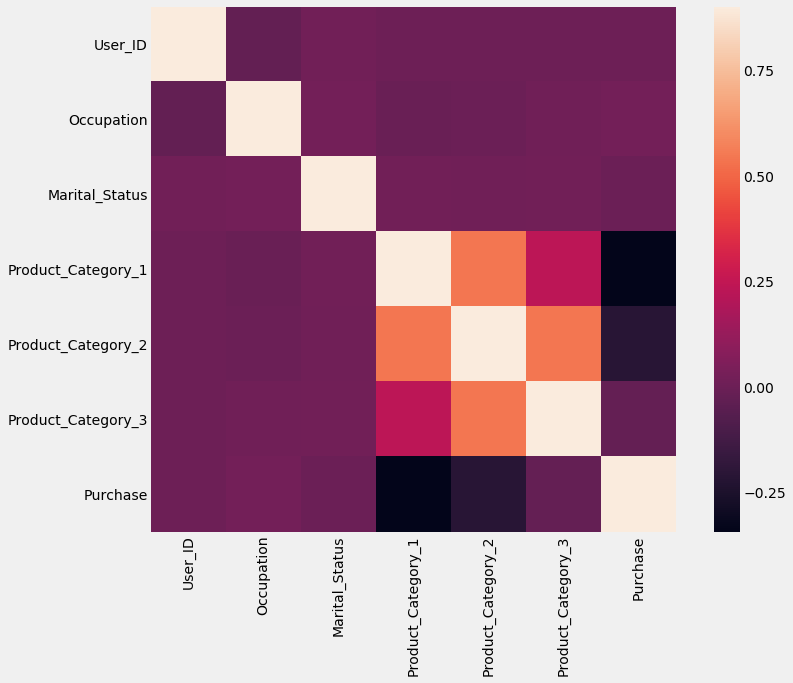

In [31]:
#correlation matrix
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=.9, square=True)

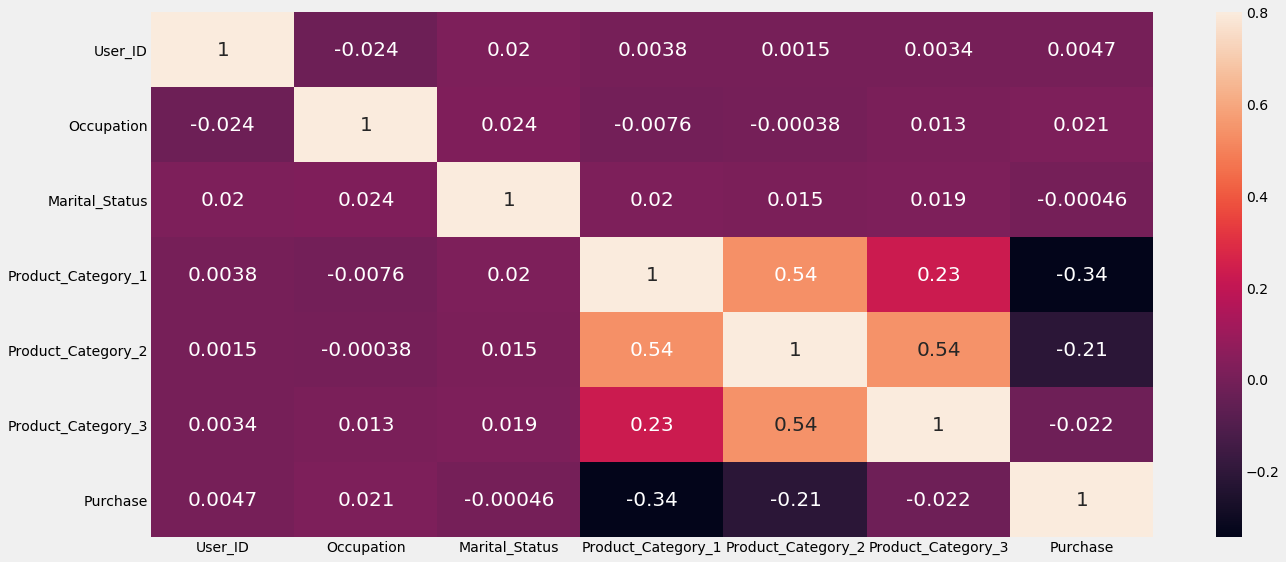

In [32]:
#correlation matrix
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corr, vmax=.8, annot_kws={'size': 20}, annot=True);

In [33]:

#Correlations Between Attributes
#Pearson’s Correlation
#Coefficient, that assumes a normal distribution of the attributes involved"""

s = corr.unstack()
#s.sort_values(kind="quicksort")
s

User_ID             User_ID               1.000000
                    Occupation           -0.023971
                    Marital_Status        0.020443
                    Product_Category_1    0.003825
                    Product_Category_2    0.001529
                    Product_Category_3    0.003419
                    Purchase              0.004716
Occupation          User_ID              -0.023971
                    Occupation            1.000000
                    Marital_Status        0.024280
                    Product_Category_1   -0.007618
                    Product_Category_2   -0.000384
                    Product_Category_3    0.013263
                    Purchase              0.020833
Marital_Status      User_ID               0.020443
                    Occupation            0.024280
                    Marital_Status        1.000000
                    Product_Category_1    0.019888
                    Product_Category_2    0.015138
                    Product_Cat

In [59]:
train.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

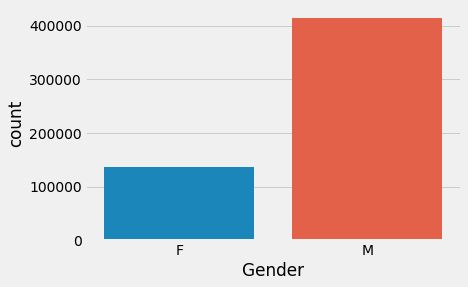

In [34]:
sns.countplot(train.Gender)

In [60]:
train.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

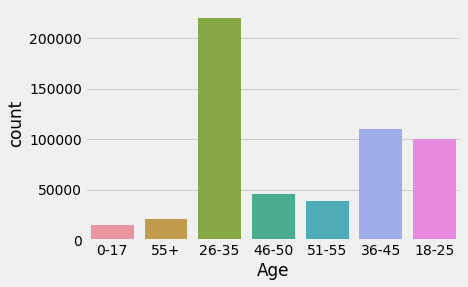

In [35]:
sns.countplot(train.Age)

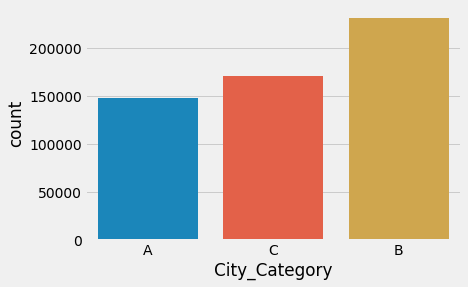

In [36]:
sns.countplot(train.City_Category)

In [62]:
train.Stay_In_Current_City_Years.value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

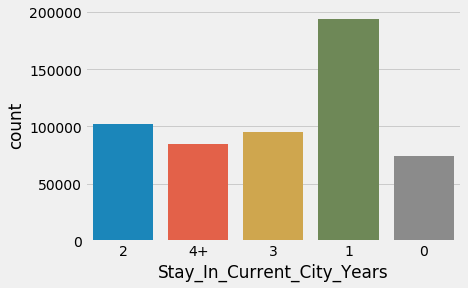

In [37]:
sns.countplot(train.Stay_In_Current_City_Years)

In [63]:
train.Purchase.values.sort()

In [64]:
train.Purchase.tail(10)

550058    23958
550059    23959
550060    23959
550061    23960
550062    23960
550063    23960
550064    23960
550065    23961
550066    23961
550067    23961
Name: Purchase, dtype: int64

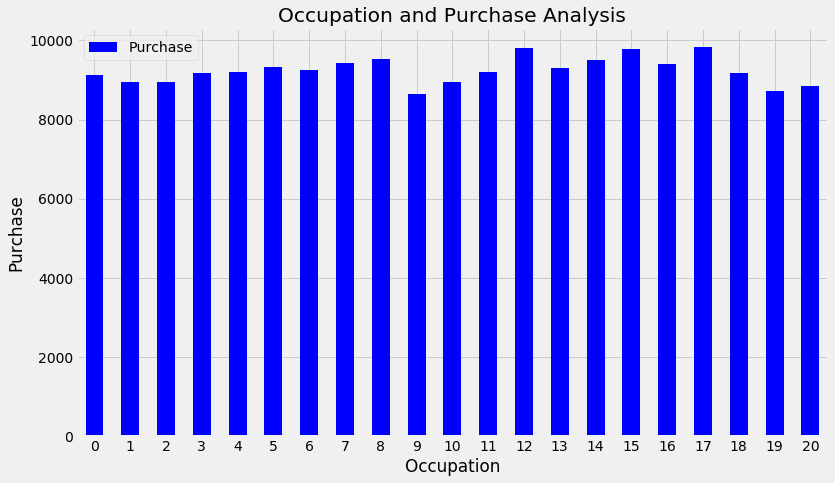

In [38]:
Occupation_pivot = \
train.pivot_table(index='Occupation', values="Purchase", aggfunc=np.mean)

Occupation_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Occupation")
plt.ylabel("Purchase")
plt.title("Occupation and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

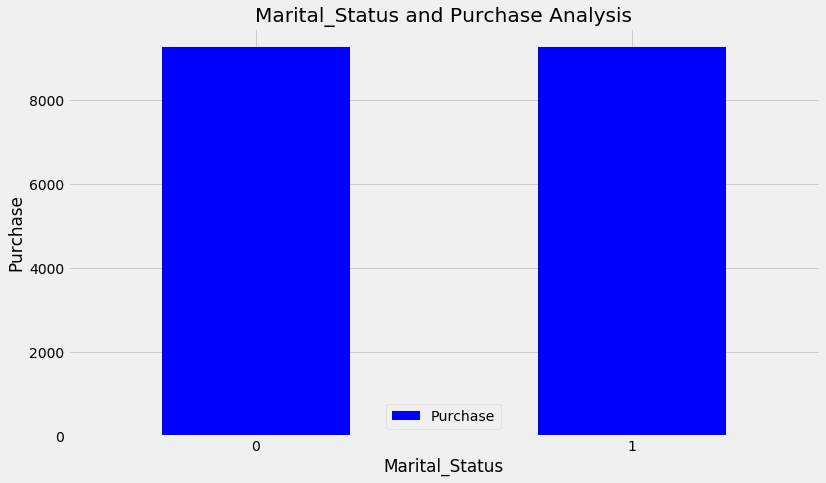

In [39]:
Marital_Status_pivot = \
train.pivot_table(index='Marital_Status', values="Purchase", aggfunc=np.mean)

Marital_Status_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Marital_Status")
plt.ylabel("Purchase")
plt.title("Marital_Status and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

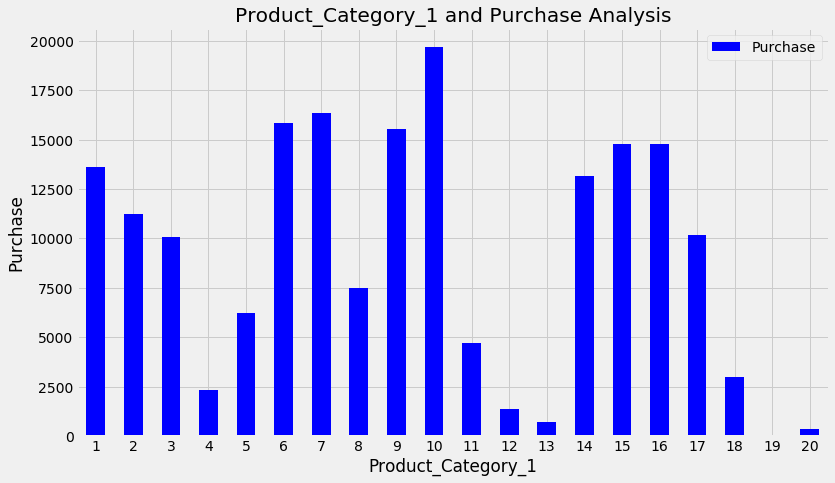

In [40]:
Product_category_1_pivot = \
train.pivot_table(index='Product_Category_1', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_1")
plt.ylabel("Purchase")
plt.title("Product_Category_1 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

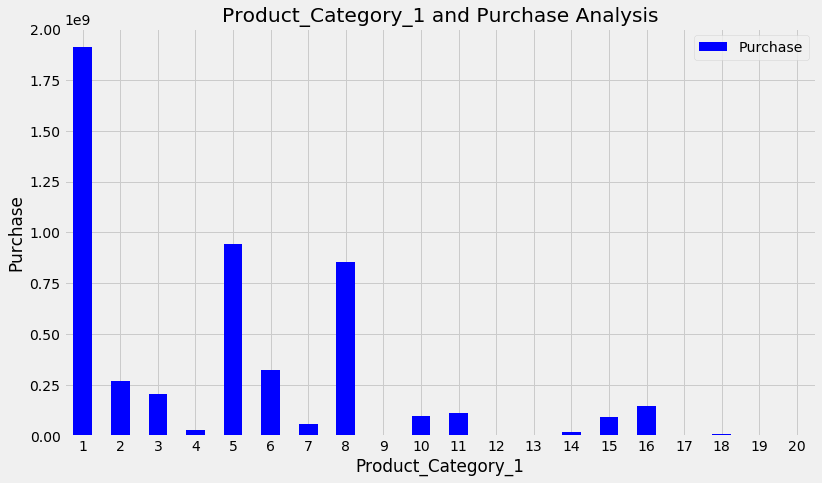

In [41]:
Product_category_1_pivot = \
train.pivot_table(index='Product_Category_1', values="Purchase", aggfunc=np.sum)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_1")
plt.ylabel("Purchase")
plt.title("Product_Category_1 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

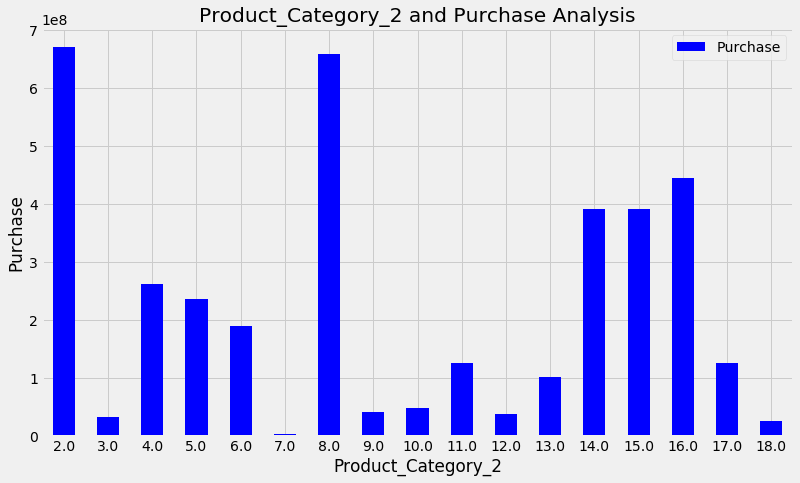

In [42]:
Product_category_1_pivot = \
train.pivot_table(index='Product_Category_2', values="Purchase", aggfunc=np.sum)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_2")
plt.ylabel("Purchase")
plt.title("Product_Category_2 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

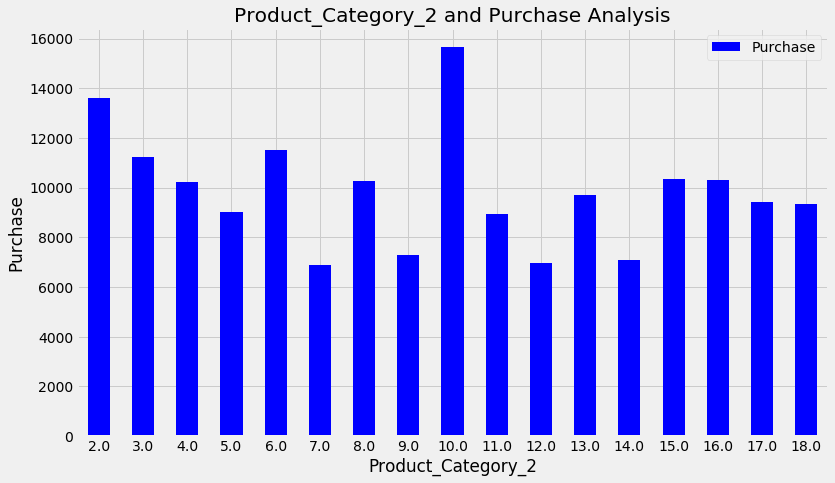

In [43]:
Product_category_1_pivot = \
train.pivot_table(index='Product_Category_2', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_2")
plt.ylabel("Purchase")
plt.title("Product_Category_2 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

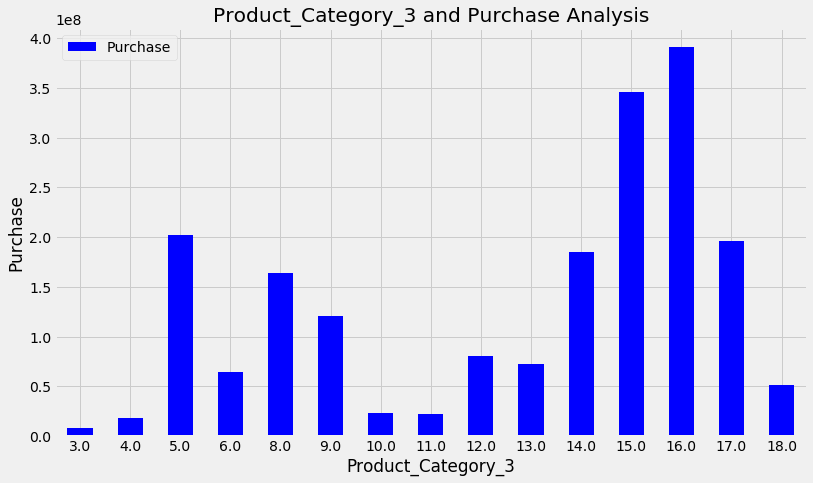

In [44]:
Product_category_1_pivot = \
train.pivot_table(index='Product_Category_3', values="Purchase", aggfunc=np.sum)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_3")
plt.ylabel("Purchase")
plt.title("Product_Category_3 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

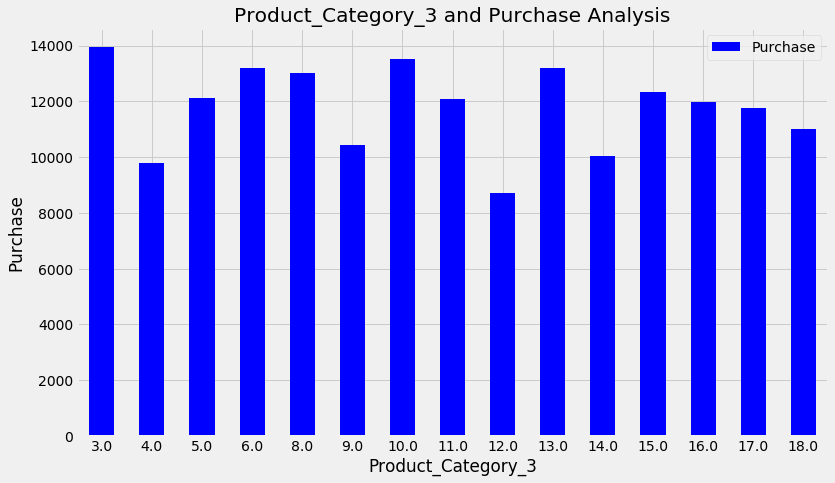

In [45]:

Product_category_1_pivot = \
train.pivot_table(index='Product_Category_3', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Product_Category_3")
plt.ylabel("Purchase")
plt.title("Product_Category_3 and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

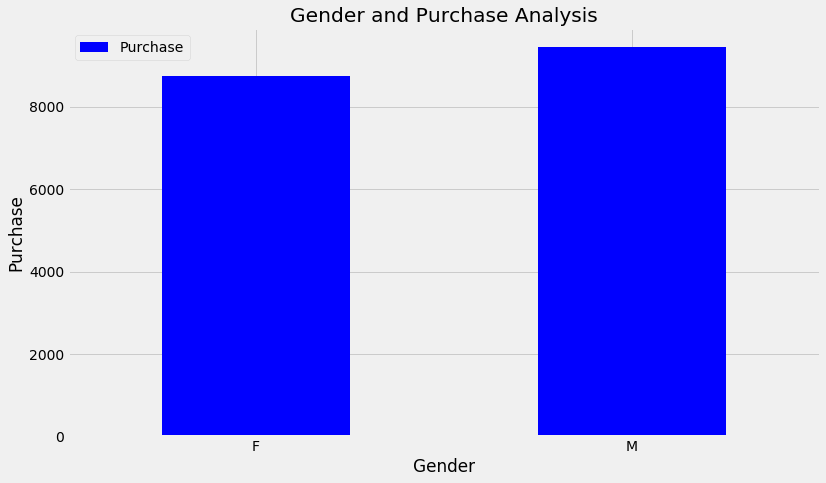

In [46]:

Product_category_1_pivot = \
train.pivot_table(index='Gender', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Gender")
plt.ylabel("Purchase")
plt.title("Gender and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

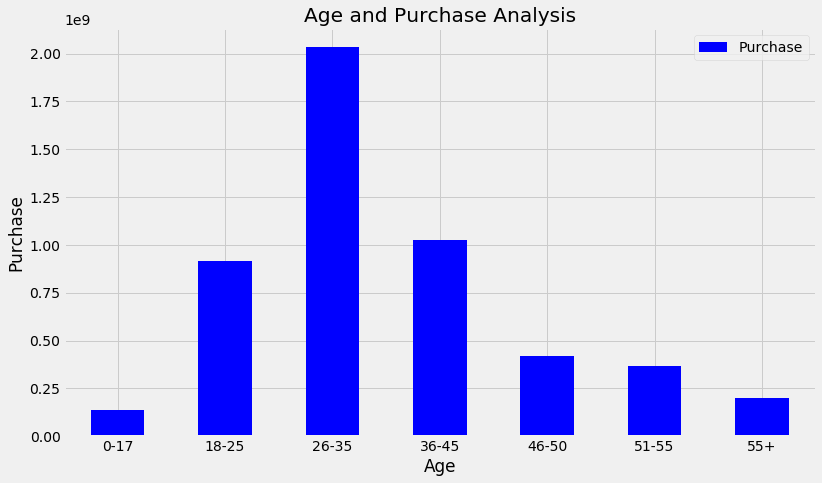

In [47]:
Product_category_1_pivot = \
train.pivot_table(index='Age', values="Purchase", aggfunc=np.sum)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Age")
plt.ylabel("Purchase")
plt.title("Age and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

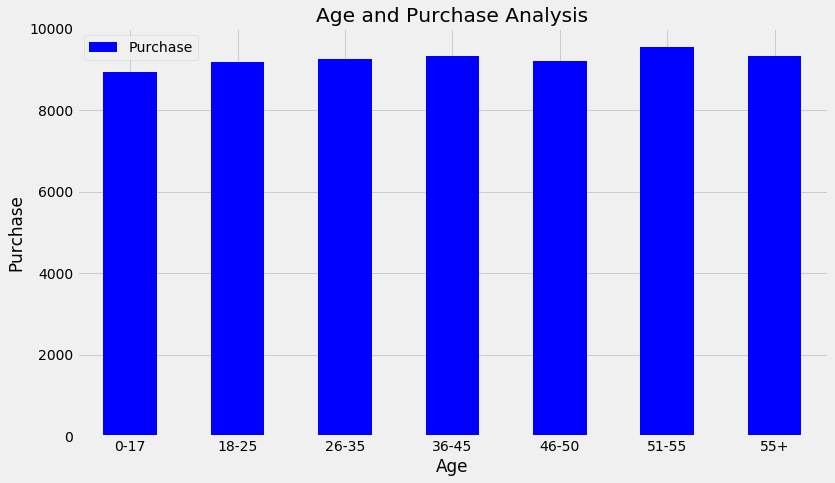

In [48]:
Product_category_1_pivot = \
train.pivot_table(index='Age', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Age")
plt.ylabel("Purchase")
plt.title("Age and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

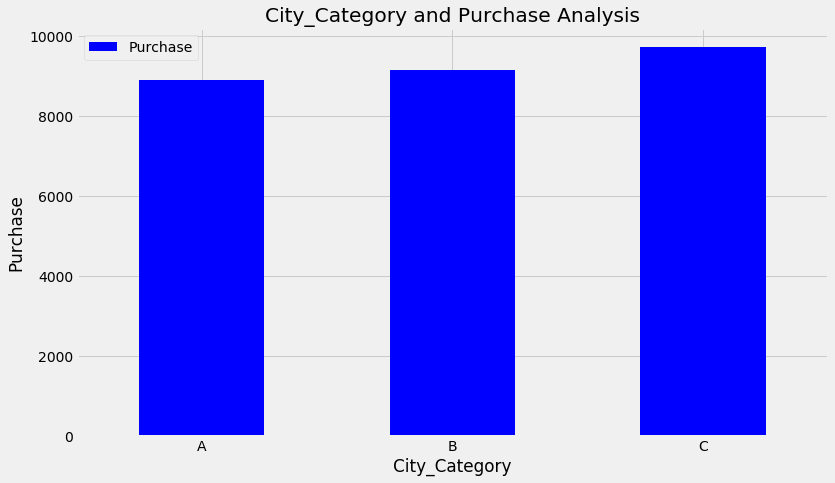

In [49]:
Product_category_1_pivot = \
train.pivot_table(index='City_Category', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("City_Category")
plt.ylabel("Purchase")
plt.title("City_Category and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

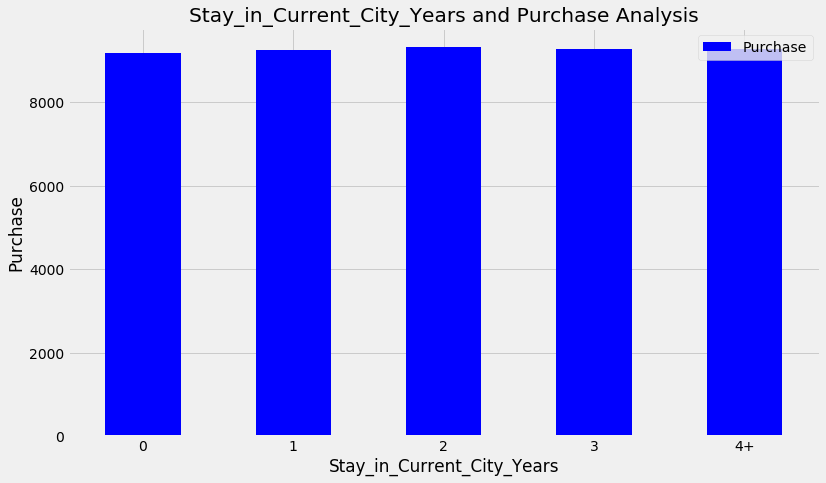

In [50]:
Product_category_1_pivot = \
train.pivot_table(index='Stay_In_Current_City_Years', values="Purchase", aggfunc=np.mean)

Product_category_1_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Stay_in_Current_City_Years")
plt.ylabel("Purchase")
plt.title("Stay_in_Current_City_Years and Purchase Analysis")
plt.xticks(rotation=0)
plt.show()

In [126]:
# Join Train and Test Dataset
train['source']='train'
test['source']='test'

data = pd.concat([train,test], ignore_index = True, sort = False)

print(train.shape, test.shape, data.shape)

(550068, 13) (233599, 12) (783667, 13)


In [127]:
#Check the percentage of null values per variable
data.isnull().sum()/data.shape[0]*100

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.388587
Product_Category_3            69.648078
Purchase                      29.808452
source                         0.000000
dtype: float64

In [128]:
#imput the value zero for NaN since NaN most likely means that the person did not buy products from these categories
data["Product_Category_2"]= \
data["Product_Category_2"].fillna(-2.0).astype("float")

In [54]:
data.Product_Category_2.value_counts().sort_index()

-2.0     245982
 2.0      70498
 3.0       4123
 4.0      36705
 5.0      37165
 6.0      23575
 7.0        854
 8.0      91317
 9.0       8177
 10.0      4420
 11.0     20230
 12.0      7801
 13.0     15054
 14.0     78834
 15.0     54114
 16.0     61687
 17.0     19104
 18.0      4027
Name: Product_Category_2, dtype: int64

In [129]:
data["Product_Category_3"]= \
data["Product_Category_3"].fillna(-2.0).astype("float")

In [56]:
data.Product_Category_3.value_counts().sort_index()

-2.0     545809
 3.0        878
 4.0       2691
 5.0      23799
 6.0       6888
 8.0      17861
 9.0      16532
 10.0      2501
 11.0      2585
 12.0     13115
 13.0      7849
 14.0     26283
 15.0     39968
 16.0     46469
 17.0     23818
 18.0      6621
Name: Product_Category_3, dtype: int64

In [66]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
source                         object
dtype: object

In [67]:
data.shape

(783667, 13)

In [130]:
#Get index of all columns with product_category_1 equal 19 or 20 from train and remove since not populated
condition = data.index[(data.Product_Category_1.isin([19,20])) & (data.source == "train")]
data = data.drop(condition)

In [131]:
data.shape

(779514, 13)

In [132]:
#Apply function len(unique()) to every data variable
data.apply(lambda x: len(x.unique()))

User_ID                        5891
Product_ID                     3672
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               18
Product_Category_2               18
Product_Category_3               16
Purchase                      17996
source                            2
dtype: int64

In [133]:
#Filter categorical variables and get dataframe will all strings columns names except Item_identfier and outlet_identifier
category_cols = data.select_dtypes(include=['object']).columns.drop(["source"])
#Print frequency of categories
for col in category_cols:
    #Number of times each value appears in the column
    frequency = data[col].value_counts()
    print("\nThis is the frequency distribution for " + col + ":")
    print(frequency)


This is the frequency distribution for Product_ID:
P00265242    2709
P00025442    2310
P00110742    2292
P00112142    2279
P00046742    2084
P00057642    2079
P00184942    2066
P00058042    2014
P00237542    1999
P00145042    1991
P00117942    1985
P00110942    1976
P00059442    1949
P00010742    1922
P00255842    1914
P00110842    1834
P00220442    1833
P00051442    1794
P00117442    1785
P00102642    1782
P00242742    1774
P00148642    1758
P00031042    1737
P00278642    1735
P00080342    1719
P00028842    1713
P00034742    1690
P00251242    1682
P00114942    1673
P00000142    1636
             ... 
P00156942       1
P00300142       1
P00077542       1
P00074742       1
P00204042       1
P00340742       1
P00309642       1
P00299042       1
P00164242       1
P00104342       1
P00322642       1
P00299342       1
P00013442       1
P00126342       1
P00077642       1
P00142542       1
P00364542       1
P0099542        1
P00064542       1
P00039042       1
P00013542       1
P00038642   

In [134]:
#Feature engineering...convert gender to binary
gender_dict = {'F':0, 'M':1}
data["Gender"] = data["Gender"].apply(lambda line: gender_dict[line])

data["Gender"].value_counts()

1    587052
0    192462
Name: Gender, dtype: int64

In [135]:
#convert age to numeric values
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
data["Age"] = data["Age"].apply(lambda line: age_dict[line])

data["Age"].value_counts()

2    311554
3    155898
1    141209
4     64902
5     54450
6     30316
0     21185
Name: Age, dtype: int64

In [136]:
#convert city_category to binary
city_dict = {'A':0, 'B':1, 'C':2}
data["City_Category"] = data["City_Category"].apply(lambda line: city_dict[line])

data["City_Category"].value_counts()

1    328524
2    241487
0    209503
Name: City_Category, dtype: int64

In [137]:
#convert stay_in_current_city_years to binary
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#New variable for outlet
data['Stay_In_Current_City_Years'] = le.fit_transform(data['Stay_In_Current_City_Years'])
    
#Dummy Variables:
data = pd.get_dummies(data, columns=['Stay_In_Current_City_Years'])

data.dtypes

User_ID                           int64
Product_ID                       object
Gender                            int64
Age                               int64
Occupation                        int64
City_Category                     int64
Marital_Status                    int64
Product_Category_1                int64
Product_Category_2              float64
Product_Category_3              float64
Purchase                        float64
source                           object
Stay_In_Current_City_Years_0      uint8
Stay_In_Current_City_Years_1      uint8
Stay_In_Current_City_Years_2      uint8
Stay_In_Current_City_Years_3      uint8
Stay_In_Current_City_Years_4      uint8
dtype: object

In [138]:
#create count features of each user
def getCountVar(compute_df, count_df, var_name):
    grouped_df = count_df.groupby(var_name)
    count_dict = {}
    for name, group in grouped_df:
        count_dict[name] = group.shape[0]

    count_list = []
    for index, row in compute_df.iterrows():
        name = row[var_name]
        count_list.append(count_dict.get(name, 0))
    return count_list


In [139]:
data["Age_Count"]  =getCountVar(data, data, "Age")
data["Occupation_Count"]  =getCountVar(data, data, "Occupation")
data["Product_Category_1_Count"]  =getCountVar(data, data,"Product_Category_1")
data["Product_Category_2_Count"]  =getCountVar(data, data, "Product_Category_2")
data["Product_Category_3_Count"]  =getCountVar(data, data,"Product_Category_3")
data["Product_ID_Count"]  =getCountVar(data, data, "Product_ID")

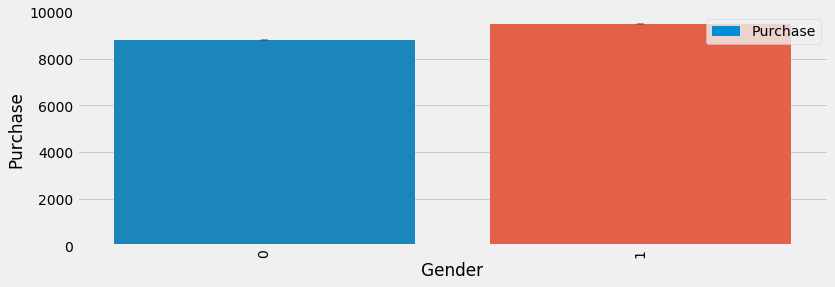

In [140]:
data[['Gender', 'Purchase']].groupby('Gender').mean().plot.bar()
sns.barplot('Gender', 'Purchase', data=data)
plt.show()

Overall:
Male shopped more than Female
Single shopped more than Married
Customers from City B shopped the most
Customers who has resided in their city for 1 year shopped the most 
Product_category_1 #1,5,8 were the most selling 
Product_category_1 #1 made the most profit
These relationships between different features can be investigated further to set the new marketing strategies to maximize the profit of the retail store (possibly for the future black Fridays). For example, the retail store may consider doing more advertisements targetting their unmarried male customers in City B on product_category_1 #1.

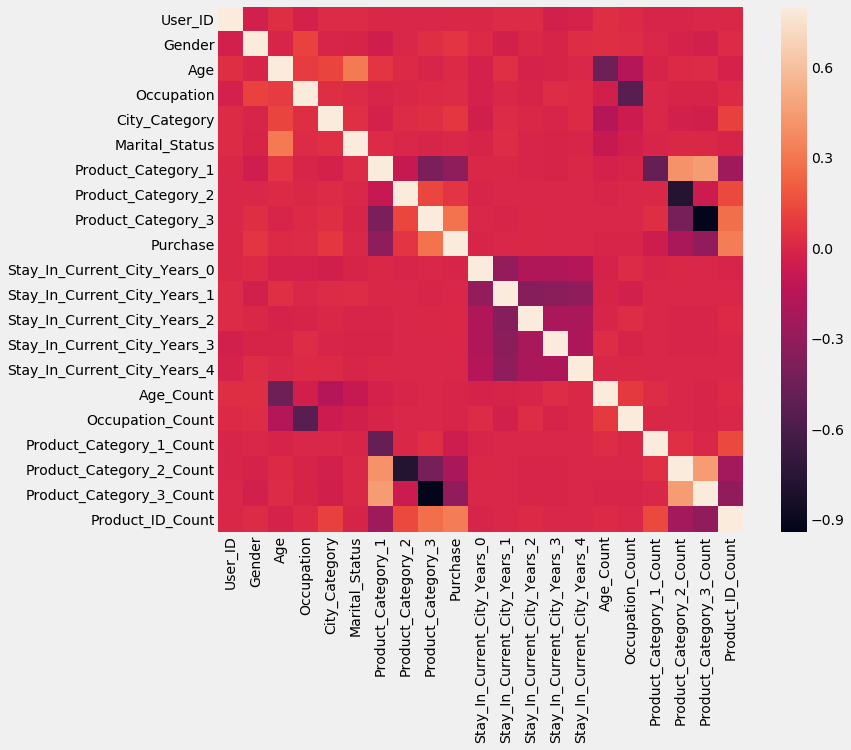

In [80]:
corrmat = data.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [141]:
#Divide into test and train
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as mods:
train.to_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\train_modified.csv', index=False)
test.to_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\test_modified.csv', index=False)

In [4]:
train_df = pd.read_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\train_modified.csv')
test_df = pd.read_csv(r'C:\Users\stefani.rangbar\Desktop\Train3\test_modified.csv')

In [198]:
test_df.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,...,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4,Age_Count,Occupation_Count,Product_Category_1_Count,Product_Category_2_Count,Product_Category_3_Count,Product_ID_Count
0,1000004,P00128942,1,4,7,1,1,1,11.0,-2.0,...,0,1,0,0,64902,83667,200699,20230,541656,1333
1,1000009,P00113442,1,2,17,2,0,3,5.0,-2.0,...,0,0,0,0,311554,57076,28791,37165,541656,371
2,1000010,P00288442,0,3,1,1,1,5,14.0,-2.0,...,0,0,0,1,155898,67329,215950,78834,541656,217
3,1000010,P00145342,0,3,1,1,1,4,9.0,-2.0,...,0,0,0,1,155898,67329,16756,8177,541656,23
4,1000011,P00053842,0,2,1,2,0,4,5.0,12.0,...,1,0,0,0,311554,67329,16756,37165,13115,781
5,1000013,P00350442,1,4,1,2,1,2,3.0,15.0,...,0,0,1,0,64902,67329,34056,4123,39968,413
6,1000013,P00155442,1,4,1,2,1,1,11.0,15.0,...,0,0,1,0,64902,67329,200699,20230,39968,602
7,1000013,P0094542,1,4,1,2,1,2,4.0,9.0,...,0,0,1,0,64902,67329,34056,36705,16532,242
8,1000015,P00161842,1,2,7,0,0,10,13.0,16.0,...,1,0,0,0,311554,83667,7373,15054,46469,166
9,1000022,P00067942,1,1,15,0,0,5,14.0,-2.0,...,0,0,0,1,141209,17257,215950,78834,541656,523


In [187]:
train_df.isnull().sum()/train_df.shape[0]*100

User_ID                         0.0
Product_ID                      0.0
Gender                          0.0
Age                             0.0
Occupation                      0.0
City_Category                   0.0
Marital_Status                  0.0
Product_Category_1              0.0
Product_Category_2              0.0
Product_Category_3              0.0
Purchase                        0.0
Stay_In_Current_City_Years_0    0.0
Stay_In_Current_City_Years_1    0.0
Stay_In_Current_City_Years_2    0.0
Stay_In_Current_City_Years_3    0.0
Stay_In_Current_City_Years_4    0.0
Age_Count                       0.0
Occupation_Count                0.0
Product_Category_1_Count        0.0
Product_Category_2_Count        0.0
Product_Category_3_Count        0.0
Product_ID_Count                0.0
dtype: float64

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
target = 'Purchase'
IDcol = ['User_ID','Product_ID']

In [179]:
#Predict training set:
train_df_predictions = my_model.predict(train_df[predictors])

# make predictions
predictions = my_model.predict(test_df[predictors])

In [6]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def modelfit(alg, dtrain, target):
    #Fit the algorithm on the data
    
    alg.fit(dtrain, target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    
    cv_score = cross_val_score(alg, dtrain,target, cv=5, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(-cv_score)
    
       
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %4g" % np.sqrt(mean_squared_error(target, dtrain_predictions)))
    print("CV Score : Mean - %4g | Std - %4g | Min - %4g | Max - %4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #print("Amount of time spent during training the model and cross validation: %4.3f seconds" % (total_time))

In [7]:
predictors = train_df.columns.drop(['Purchase','Product_ID','User_ID'])
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0.030,                 
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.95)
modelfit(xgb_model, train_df[predictors], train_df['Purchase'])

C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:59:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:29:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:54:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\stefani.rangbar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:05:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
RMSE : 2664.32
CV Score : Mean - 2691.86 | Std - 8.51042 | Min - 2683.75 | Max - 2707.36


In [14]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.07, n_estimators=1000, max_depth=5,
 min_child_weight=1.5, gamma=0.03, subsample=0.95, colsample_bytree=0.4,
 nthread=4, scale_pos_weight=1, seed=27, reg_alpah=0.75, reg_lambda=0.45), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[target])
gsearch1.best_params_, gsearch1.best_score_


                                                                                     
                

[06:05:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 9, 'min_child_weight': 5}, -6785783.67973908)

In [16]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", gsearch1.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gsearch1.best_score_)))

Best parameters found:  {'max_depth': 9, 'min_child_weight': 5}
Lowest RMSE found:  2604.9536809200813
